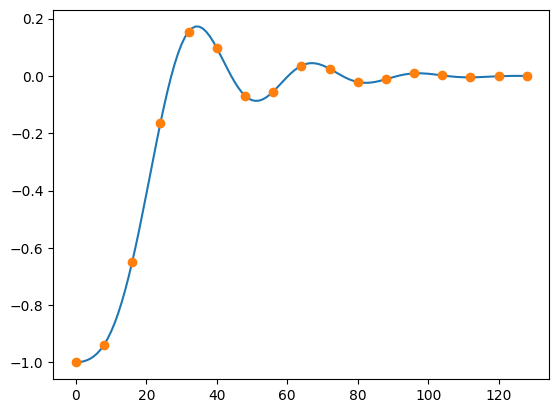

In [266]:
import numpy as np
from scipy.signal import minimum_phase
import matplotlib.pyplot as plt
blep_os = 16
radius = 128 # with oversample 2 we end up stepping thru this stride (blep_os/2).
L=radius*2+1
fc=0.5/blep_os
n = np.arange(L) - radius
h_lin = 2 * fc * np.sinc(2 * fc * n) * np.blackman(L)
h_min = minimum_phase(h_lin, method='homomorphic')
blep = np.cumsum(h_min)
blep = (blep-blep[0])/(blep[-1]-blep[0]) - 1
plt.plot(blep)
plt.plot(np.arange(0, len(blep), 8), blep[::8], 'o')

In [271]:
# Print blep as a C source code array of floats
print(f"static const float minblep[{len(blep)}] = {'{'} // minBLEP correction for a unit step input; {blep_os}x oversampling")
for i, v in enumerate(blep):
    end = ",\n" if (i+1)%8==0 else ", "
    if i == len(blep)-1:
        end = "\n"
    print("%.9ff" % v, end=end)
print("};")


static const float minblep[129] = { // minBLEP correction for a unit step input; 16x oversampling
-1.000000000f, -0.998811289f, -0.996531062f, -0.992795688f, -0.987211296f, -0.979364361f, -0.968834290f, -0.955206639f,
-0.938089255f, -0.917128234f, -0.892024074f, -0.862547495f, -0.828554201f, -0.789997837f, -0.746941039f, -0.699562613f,
-0.648161606f, -0.593157579f, -0.535086789f, -0.474594145f, -0.412420965f, -0.349388355f, -0.286377554f, -0.224307123f,
-0.164107876f, -0.106696390f, -0.052947974f, -0.003670049f, 0.040422752f, 0.078731454f, 0.110792191f, 0.136291501f,
0.155076819f, 0.167161723f, 0.172725675f, 0.172108498f, 0.165799199f, 0.154419794f, 0.138704628f, 0.119475970f,
0.097616810f, 0.074041890f, 0.049667838f, 0.025383909f, 0.002024209f, -0.019657569f, -0.039010001f, -0.055501624f,
-0.068733874f, -0.078448626f, -0.084530510f, -0.087003901f, -0.086024863f, -0.081868483f, -0.074912196f, -0.065615874f,
-0.054499809f, -0.042121280f, -0.029050821f, -0.015849132f, -0.003045552f, 0.00

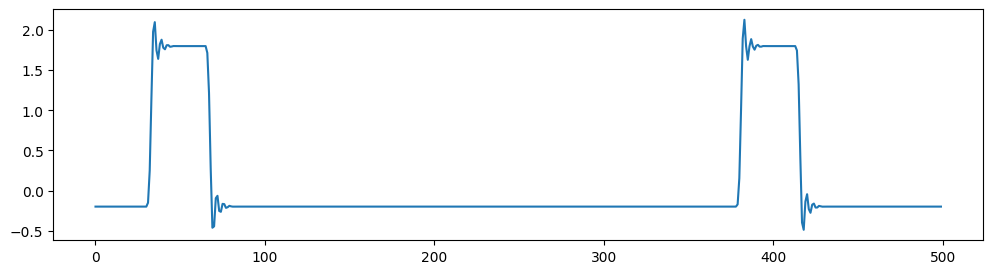

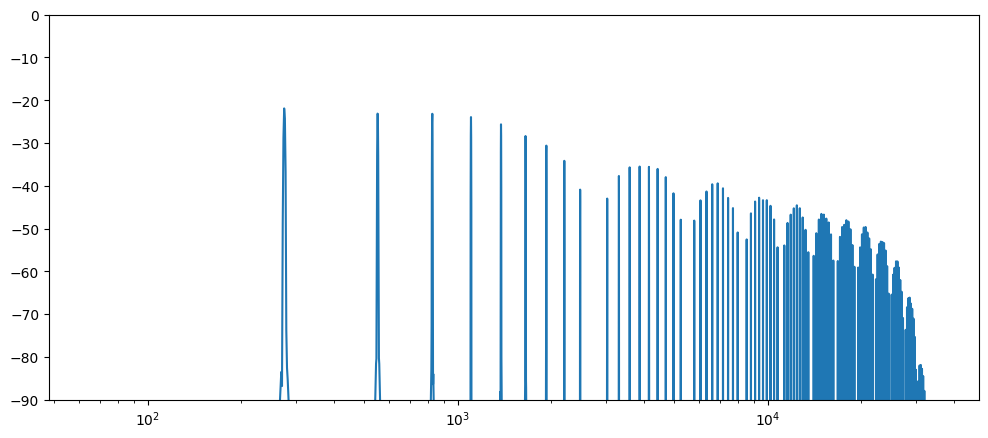

In [278]:
outp=[]
phase=0.81
dphase=0.00287235
def blepsaw(phase, dphase):
    saw = phase*2-1
    bleppos = (phase/dphase*(blep_os/2))
    if (bleppos<len(blep)-1):
        i = int(bleppos)
        saw -= 2 * (blep[i]+(blep[i+1]-blep[i])*(bleppos-i))
    return saw
for i in range(65536):
    phase=(phase+dphase)%1
    saw = blepsaw(phase, dphase)
    saw2 = blepsaw((phase+0.1)%1, dphase)
    outp.append(saw-saw2)
plt.figure(figsize=(12, 3))
plt.plot(outp[0:500])
plt.show()
from numpy.fft import fft, ifft
db = 20*np.log10(np.abs(fft(np.array(outp) * np.blackman(len(outp))) / len(outp)))
plt.figure(figsize=(12, 5))
Fs= 96000
xs=np.arange(len(db))*Fs/len(db)
plt.plot(xs[0:32768], db[0:32768])
plt.xlim(48, 48000)
plt.ylim(-90,0)
plt.xscale('log')
plt.show()
from IPython.display import Audio, display
display(Audio(np.array(outp)*0.75, rate=96000))